In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


In [2]:
def get_largest_graph(input_file):
    # Read the graph from the input file
    adj_matrix = pd.read_csv(input_file, index_col=0)
    G = nx.from_pandas_adjacency(adj_matrix)
    
    # Find the largest connected component
    largest_cc = max(nx.connected_components(G), key=len)
    
    # Create a subgraph with only the nodes in the largest connected component
    largest_subgraph = G.subgraph(largest_cc)
    
    return largest_subgraph

In [3]:
def generate_graph(input_file):
    adj_matrix = pd.read_csv(input_file, index_col=0)
    G = nx.from_pandas_adjacency(adj_matrix)
    G.remove_nodes_from(list(nx.isolates(G)))
    subgraphs = [subgraph for subgraph in nx.connected_components(G) if len(subgraph) > 5]
    G = G.subgraph(set().union(*subgraphs)).copy()
    return G

In [4]:
def plot_graph_generic(G,title,node_color="tab:blue", node_size=50, edge_color="gray",cmap=None):
    plt.figure()
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos=pos, with_labels=False, node_size=node_size, node_color=node_color, edge_color=edge_color, alpha=0.7,cmap=cmap)
    plt.title(title)
    if cmap:
        if cmap == plt.cm.tab10:
            sm = plt.cm.ScalarMappable(cmap=plt.cm.tab10, norm=plt.Normalize(vmin=min(node_color), vmax=max(node_color)))
            sm.set_array([])
            plt.colorbar(sm)
        else:
            sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(node_color), vmax=max(node_color)))
            sm.set_array([])
            plt.colorbar(sm)
    plt.show()

In [5]:
def plot_graph_spectral(G,title,node_color="tab:blue", node_size=50, edge_color="gray",cmap=None):
    plt.figure()
    nx.draw_spectral(G, with_labels=False, node_size=node_size, node_color=node_color, edge_color=edge_color, alpha=0.7,cmap=cmap)
    plt.title(title)
    plt.show()

In [6]:
def color_by_taxa(G):

    cda = taxa[taxa['Genus'] == "Candidatus Desulforudis"]["SNV"].to_list()
    B = taxa[taxa['Phylum'] == "Bacillota"]["SNV"].to_list()
    P = taxa[taxa['Order'] == "Burkholderiales"]["SNV"].to_list()
    O = taxa[taxa['Phylum'] == "Thermodesulfobacteriota"]["SNV"].to_list()
    C = taxa[taxa['Class'] == "Thermodesulfovibrionia"]["SNV"].to_list()
    R = taxa[taxa['Phylum'] == "Spirochaetota"]["SNV"].to_list()
    chl = taxa[taxa['Phylum'] == "Chloroflexi"]["SNV"].to_list()
    alph = taxa[taxa['Class'] == "Alphaproteobacteria"]["SNV"].to_list()
    ig = taxa[taxa['Phylum'] == "Ignavibacterota"]["SNV"].to_list()
    colors = {
    'Desulforudis':'#a5cee0', 'Hydrogenophaga':'#6a3e98', 'Uncl. Comomonadaceae':'#c8b3d7',
    'Thermodesulfobacteriota':'#f58120', 'Alphaproteobacteria':'#f69799',
    'Thermodesulfovibrionia':'#b7d885', 'Bacillota':'#1f78b4', 'Spirochaetota':'#808080',
    'Nitrospirota':'#808080', 'Actinomycetota':'#808080'
}

    colors = []
    for node in G.nodes():
        if node in B:
            colors.append("#1f78b4")
        elif node in cda:
            colors.append("#a5cee0")
        elif node in O:
            colors.append("#f58120")
        elif node in C:
            colors.append("#b7d885")
        elif node in alph:
            colors.append("#f69799")
        elif node in P:
            colors.append("tab:purple")
        elif node in chl:
            colors.append("#2f9e2a")
        elif node in ig:
             colors.append("#e3191c")
        elif node in R:
            colors.append("tab:brown")
        else:
            colors.append("tab:gray")
    return colors

In [7]:
def get_unique_nodes(graphA, graphB):
    nodesA = set(graphA.nodes())
    nodesB = set(graphB.nodes())
    only_graphA = nodesA - nodesB
    only_graphB = nodesB - nodesA
    return only_graphA, only_graphB


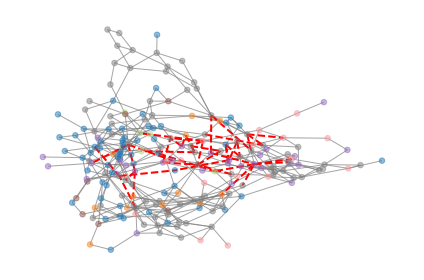

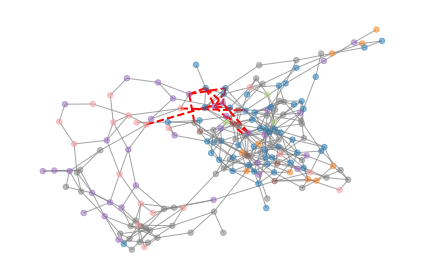

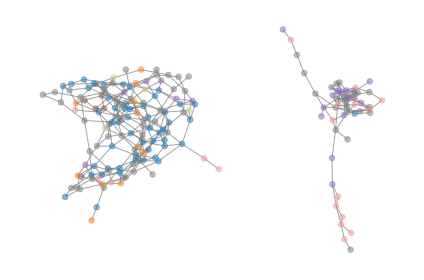

In [8]:

taxa = pd.read_csv("Data/taxa_table.csv", index_col=0)

def combine_graphs(G_pos, G_neg):
    # Add interaction type to edges
    for u, v in G_pos.edges():
        G_pos[u][v]['interaction'] = 'positive'

    for u, v in G_neg.edges():
        G_neg[u][v]['interaction'] = 'negative'

    G_combined = nx.compose(G_pos, G_neg)


    pos = nx.spring_layout(G_combined, seed=12)

    # Separate edges by interaction type
    positive_edges = [(u, v) for u, v, d in G_combined.edges(data=True) if d['interaction'] == 'positive']
    negative_edges = [(u, v) for u, v, d in G_combined.edges(data=True) if d['interaction'] == 'negative']

    nx.draw_networkx_nodes(G_combined, pos, node_color=color_by_taxa(G_combined), node_size=30,alpha=0.5)

    nx.draw_networkx_edges(G_combined, pos, edgelist=positive_edges, edge_color='gray', width=1,alpha=0.7)
    nx.draw_networkx_edges(G_combined, pos, edgelist=negative_edges, edge_color='red', style='dashed', width=2)


    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return(G_combined)




G_water_pos = generate_graph("Data/water_pos.csv")
G_water_neg = generate_graph("Data/water_neg.csv")

gwc = combine_graphs(G_water_pos, G_water_neg)


G_rock_pos = generate_graph("Data/rock_pos.csv")
G_rock_neg = generate_graph("Data/rock_neg.csv")

grc = combine_graphs(G_rock_pos, G_rock_neg)

G_glass_pos = generate_graph("Data/glass_pos.csv")
G_glass_neg = generate_graph("Data/glass_neg.csv")

ggc = combine_graphs(G_glass_pos, G_glass_neg)



In [9]:
def graph_connectedness_metrics(G):
    return {
        "avg_degree": sum(dict(G.degree()).values()) / G.number_of_nodes(),
        "density": nx.density(G),
        "avg_centrality": sum(nx.degree_centrality(G).values()) / G.number_of_nodes(),
        "num_components": nx.number_connected_components(G),
        "modularity": nx.algorithms.community.quality.modularity(G, list(nx.algorithms.community.greedy_modularity_communities(G)))
    }

print('Water',graph_connectedness_metrics(gwc))
print('Rock',graph_connectedness_metrics(grc))
print('Glass',graph_connectedness_metrics(ggc))

Water {'avg_degree': 3.9617224880382773, 'density': 0.019046742730953258, 'avg_centrality': 0.019046742730953258, 'num_components': 1, 'modularity': 0.668676631893393}
Rock {'avg_degree': 4.163934426229508, 'density': 0.022878760583678617, 'avg_centrality': 0.022878760583678576, 'num_components': 1, 'modularity': 0.6548074207259527}
Glass {'avg_degree': 3.879120879120879, 'density': 0.021431607066966184, 'avg_centrality': 0.021431607066966188, 'num_components': 2, 'modularity': 0.6572839843028995}
